In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLP
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_sample_path

# Guiding conditional cell diffusion process
We now exam a cell differentiation and development model from _Quantifying the Waddington landscape and biological paths for development and differentiation. Wang et.al._, which is a two-dimensional diffusion process governed by the pair of 1D SDEs:
$$
\mathrm{d}X_{t,1} = \left\{\frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} + \frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} - X_{t,1}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,1} \\
\mathrm{d}X_{t,2} = \left\{\frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} + \frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} - X_{t,2}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a highly nonlinear process with no closed-form solution of conditional bridges. We choose the linear auxiliary process as:
$$
\mathrm{d}\tilde{X}_{t,1} = - \tilde{X}_{t,1}\mathrm{d}t + \sigma\mathrm{d}W_{t,1}\\
\mathrm{d}\tilde{X}_{t,2} = - \tilde{X}_{t,2}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a 2D Ornstein-Uhlenbeck process.

In [31]:
dim = 2
T = 4.0
dt = 1.0 / 40
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

seed = 42
u = jnp.array([0.1, -0.1], dtype=dtype)
v = jnp.array([2.0, -0.1], dtype=dtype)
# v = jnp.array([1.0, -0.1], dtype=dtype) # probably rare event

In [32]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
ori_proc = CellDiffusionProcess(alpha, sigma, T, dim, dtype)
aux_proc = CellDiffusionAuxProcess(alpha, sigma, T, dim, dtype)

guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

ori_solver = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver = Euler(sde=aux_proc, wiener=wiener_proc)
guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}, xlabel='$t$', ylabel='$x$'>

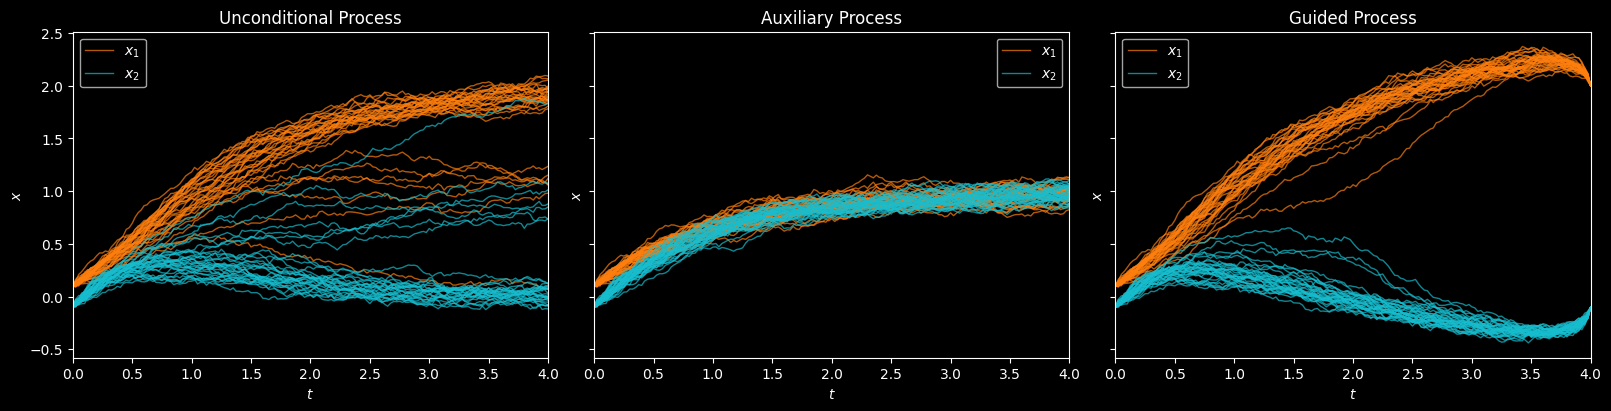

In [33]:
batch_size = 32
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
guided_path = guided_solver.solve(
    x0=u, 
    rng_key=rng_key, 
    batch_size=batch_size, 
    enforce_end_point=v
)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(ori_path, ax=axes[0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Unconditional Process")
plot_sample_path(aux_path, ax=axes[1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Auxiliary Process")
plot_sample_path(guided_path, ax=axes[2], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Process")

In [35]:
jax.nn.softmax(guided_bridge_path.log_ll, axis=-1)

Array([1.10595421e-17, 2.61996229e-06, 4.51023008e-17, 1.80132784e-10,
       2.05533243e-15, 4.33500647e-13, 1.24834454e-08, 4.26709618e-14,
       1.55478984e-20, 1.52800372e-02, 1.20213828e-09, 2.70349465e-10,
       6.16407475e-16, 1.05826196e-13, 2.35531256e-12, 2.73055800e-09,
       1.78389668e-18, 7.40704766e-14, 3.04856916e-13, 1.51457741e-14,
       2.84914842e-10, 4.95787526e-06, 1.10322958e-14, 3.87094870e-12,
       3.80851395e-09, 5.85668599e-14, 4.78582191e-12, 2.91619557e-07,
       9.84712005e-01, 3.24708427e-10, 5.91165385e-15, 1.35865214e-23],      dtype=float32)

In [6]:
net = MLP(
    out_dim=dim, 
    hidden_dims=(32, 64, 32),
    norm="batch",
    t_emb_dim=32,
    t_emb_max_period=500.0,
    t_emb_scaling=100.0
)

In [29]:
train_config = {
    "save_name": "cell_model",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 128,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 1000
}

In [30]:
model = neurb.NeuralBridge(guided_proc, net, train_config)

In [31]:
model.initialize_path_solver(wiener_proc)
losses = model.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: 112.43530
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_1


Epoch 2:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -216.82925
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_2


Epoch 3:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -262.91205
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_3


Epoch 4:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -287.47229
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_4


Epoch 5:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -304.57675
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_5


Epoch 6:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -307.59274
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_6


Epoch 7:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -321.87048
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_7


Epoch 8:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -315.70639
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_8


Epoch 9:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -330.96576
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_9


Epoch 10:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -323.67468
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model/epoch_10


In [44]:
neural_bridge = model.build_neural_bridge()

In [33]:
neural_bridge_solver = Euler(neural_bridge, wiener_proc)
neural_bridge_path = neural_bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

In [50]:
pCN_config = {
    "seed": seed,
    "rho": 0.98,
    "batch_size": 16,
    "n_iters": 5000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN(log_every=1000)

Running for 5,000 iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

INFO:root:Iteration 0/5000: log likelihood = 179.11996459960938
INFO:root:Iteration 1000/5000: log likelihood = 268.74237060546875
INFO:root:Iteration 2000/5000: log likelihood = 274.6443786621094
INFO:root:Iteration 3000/5000: log likelihood = 272.22076416015625
INFO:root:Iteration 4000/5000: log likelihood = 293.0694580078125
INFO:root:Batch average acceptance rate: 33.06%


In [65]:
sm_train_config = {
    "save_name": "cell_model",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 32,
    "n_iters": 2000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 250
}

In [66]:
neural_net = MLP(
    out_dim=dim, 
    hidden_dims=(32, 64, 32),
    norm="batch",
    t_emb_dim=32,
    t_emb_max_period=500.0,
    t_emb_scaling=100.0
)
sm_reverse_bridge = scorematching.ScoreMatchingReversedBridge(ori_proc, neural_net, sm_train_config)
sm_reverse_bridge.initialize_path_solver(wiener_proc)
losses = sm_reverse_bridge.train_reversed_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: 158.82170
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_1


Epoch 2:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: 157.10347
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_2


Epoch 3:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: 155.55453
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_3


Epoch 4:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: 154.63853
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_4


Epoch 5:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: 153.96254
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_5


Epoch 6:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: 153.66634
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_6


Epoch 7:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: 153.28136
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_7


Epoch 8:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: 152.93597
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_8


Epoch 9:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: 152.89441
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_9


Epoch 10:   0%|          | 0/2000 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: 152.84360
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_10


In [70]:
reversed_bridge = sm_reverse_bridge.build_reversed_bridge()
reversed_bridge_solver = Euler(reversed_bridge, wiener_proc)
reversed_bridge_path = reversed_bridge_solver.solve(x0=v, rng_key=jax.random.PRNGKey(seed), batch_size=16, enforce_end_point=u)

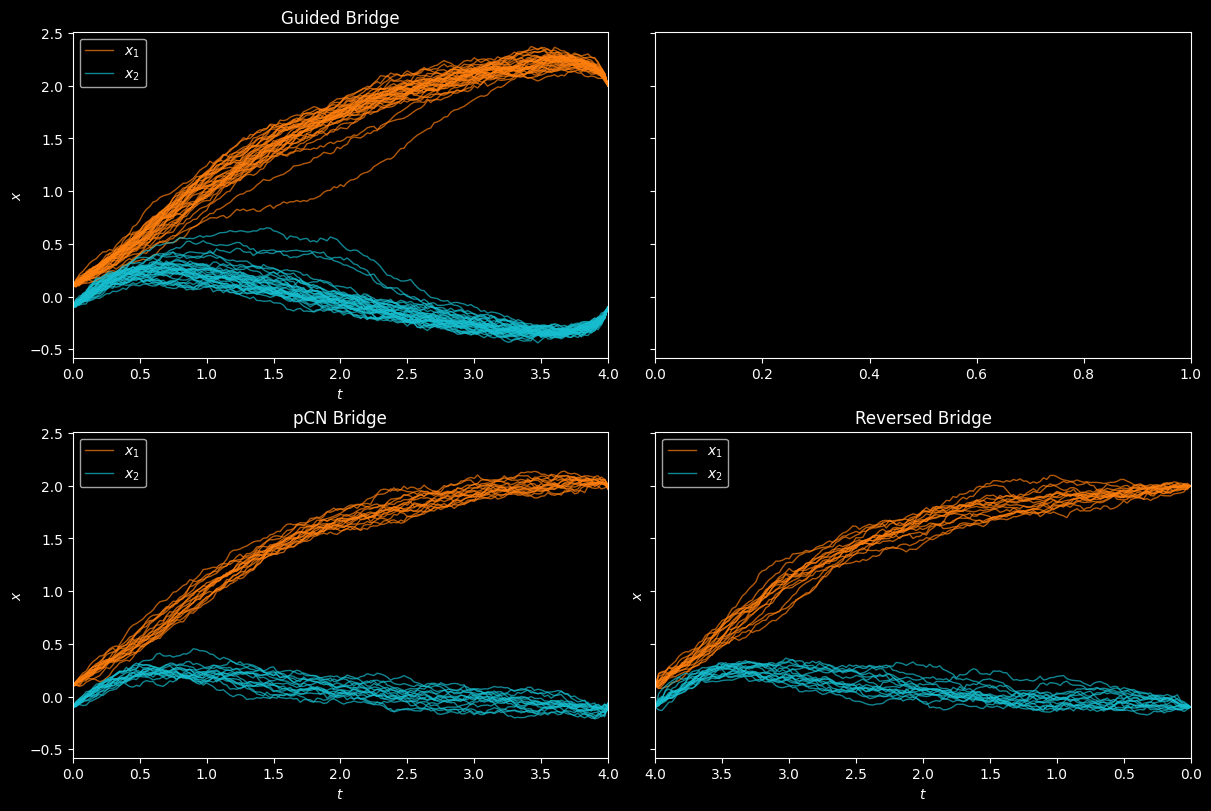

In [75]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), layout="constrained", sharey=True)
plot_sample_path(guided_path, ax=ax[0, 0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Bridge")
# plot_sample_path(neural_bridge_path, ax=ax[0, 1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plot_sample_path(pCN_result.path_X, ax=ax[1, 0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="pCN Bridge")
plot_sample_path(reversed_bridge_path, ax=ax[1, 1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Reversed Bridge")
ax[1, 1].invert_xaxis()